# WIP

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt

In [22]:
def load_data(bin=False):
    project_dir = os.path.dirname(os.path.abspath(''))
    df = pd.read_json(os.path.join(project_dir, 'model_prepped_dataset.json'))
    X = df.loc[:, ~df.columns.isin(['Outcome', 'Outcome_Bin_H'])]
    if bin:
        y = df['Outcome_Bin_H']
    else:
        y = df['Outcome']
    return X, y

def prep_datasets(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

def compare_models(models, X_train, y_train, y_test):
    for model in models:
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        accu = accuracy_score(y_test, y_pred) * 100
        print(
            f"{model[0]}: "
            f"Accuracy: {accu:.2f}"
            )
    return

In [4]:
np.random.seed(2)

models = [
    ('lgr', make_pipeline(StandardScaler(), LogisticRegression())),
    ('rfc', RandomForestClassifier(max_depth=2)),
    ('knn', KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier()),
    ('abc', AdaBoostClassifier()),
    ('gbc', GradientBoostingClassifier())
    ]

X, y = load_data(bin=True)
X_train, X_test, y_train, y_test = prep_datasets(X, y)
compare_models(models, X_train, y_train, y_test)

lgr: Accuracy: 61.20
rfc: Accuracy: 59.29
knn: Accuracy: 56.98
dtc: Accuracy: 53.86
abc: Accuracy: 60.66
gbc: Accuracy: 61.29


<BarContainer object of 18 artists>

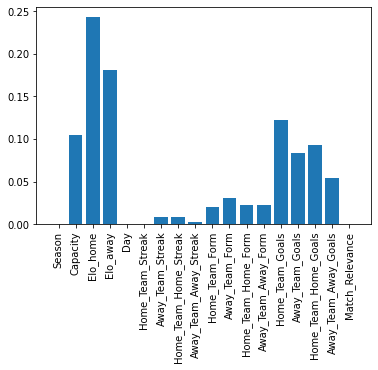

In [5]:
plt.xticks(rotation=90)
plt.bar(list(X), models[1][1].feature_importances_)

Logistic regression is most accurate model so will be validated and tuned.

hyperparameter tuning with different cross validation techniques

Split your dataset into three folds: train, validation, and test. Then, perform the model selection and hyperparameter search, each time training on the train set, and checking the score on the validation set.

Split into two folds: train and test, and then perform cross-validations on the train set to do the model selection and hyperparameter search. This time, you don't have one validation set but as many as you have folds on your CV, so this is more robust (if your model does not take too long to train).

In [6]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [25]:
X, y = load_data(bin=True)
X_train, X_test, y_train, y_test = prep_datasets(X, y)

model = make_pipeline(StandardScaler(), LogisticRegression())

cv = KFold(n_splits=10, random_state=1, shuffle=True)
tscv = TimeSeriesSplit(n_splits=10)
btscv = BlockingTimeSeriesSplit(n_splits=10)

print(f"K-Fold CV: {cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1, scoring='accuracy')}'")
print(f"Time Series CV: {cross_val_score(model, X_train, y_train, cv=tscv, n_jobs=-1, scoring='accuracy')}")
print(f"Blocking Time Series CV: {cross_val_score(model, X_train, y_train, cv=btscv, n_jobs=-1, scoring='accuracy')}")

K-Fold CV: [0.60933411 0.60904333 0.60971354 0.61553003 0.60506035 0.60956813
 0.6164025  0.61422132 0.60157045 0.61174931]'
Time Series CV: [0.60588612 0.61916187 0.60828535 0.61084453 0.61388356 0.60396673
 0.60940499 0.61852207 0.60588612 0.59836852]
Blocking Time Series CV: [0.60465116 0.60973837 0.58139535 0.61991279 0.60901163 0.58357558
 0.61773256 0.61627907 0.62063953 0.59593023]


In [19]:
X, y = load_data(bin=True)
X_train, X_test, y_train, y_test = prep_datasets(X, y)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

model = LogisticRegression()
# define search space 
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jonny/miniconda3/lib/python3.9/site-packages/sklearn/linear_mode

Best Score: 0.6102629289307068
Best Hyperparameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


tests

https://towardsdatascience.com/validating-your-machine-learning-model-25b4c8643fb7

In [26]:
mod_1 = cross_val_score(models[0][1], X_train, y_train, cv=cv)
mod_2 = cross_val_score(models[5][1], X_train, y_train, cv=cv)

In [40]:
from scipy.stats import wilcoxon
# Calculate p value
stat, p = wilcoxon(mod_1, mod_2, zero_method='zsplit')
stat, p

(19.0, 0.431640625)

We can apply this significance test for comparing two Machine Learning models. Using k-fold cross-validation we can create, for each model, k accuracy scores. This will result in two samples, one for each model.
Then, we can use the Wilcoxon signed-rank test to test if the two samples differ significantly from each other. If they do, then one is more accurate than the other.

The result will be a p-value. If that value is lower than 0.05 we can reject the null hypothesis that there are no significant differences between the models.
NOTE: It is important that you keep the same folds between the models to make sure the samples are drawn from the same population. This is achieved by simply setting the same random_state in the cross-validation procedure.

McNemar’s test is used to check the extent to which the predictions between one model and another match. This is referred to as the homogeneity of the contingency table. From that table, we can calculate x² which can be used to compute the p-value:

Again, if the p-value is lower than 0.05 we can reject the null hypothesis and see that one model is significantly better than the other.
We can use mlxtend package to create the table and calculate the corresponding p-value:

In [51]:
import numpy as np
from mlxtend.evaluate import mcnemar_table, mcnemar


y_mod_1 = models[0][1].predict(X_train)
y_mod_2 = models[5][1].predict(X_train)

# Calculate p value
tb = mcnemar_table(y_target=y_train, 
                   y_model1=y_mod_1, 
                   y_model2=y_mod_2)
chi2, p = mcnemar(ary=tb, exact=True)

print('chi-squared:', chi2)
print('p-value:', p)

chi-squared: 2743
p-value: 3.0434026173540566e-13


The 5x2CV paired t-test is a method often used to compare Machine Learning models due to its strong statistical foundation.
The method works as follows. Let’s say we have two classifiers, A and B. We randomly split the data in 50% training and 50% test. Then, we train each model on the training data and compute the difference in accuracy between the models from the test set, called DiffA. Then, the training and test splits are reversed and the difference is calculated again in DiffB.
This is repeated five times after which the mean variance of the differences is computed (S²). Then, it is used to calculate the t-statistic:

NOTE: You can use the combined 5x2CV F-test instead which was shown to be slightly more robust (Alpaydin, 1999). This method is implemented in mlxtend as
from mlxtend.evluate import combined_ftest_5x2cv.

In [53]:
from mlxtend.evaluate import paired_ttest_5x2cv

# Calculate p-value
t, p = paired_ttest_5x2cv(estimator1=models[0][1],
                          estimator2=models[5][1],
                          X=X_train, y=y_train,
                          random_seed=1)